In [ ]:
3a!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install


/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
0.6

--------------

0.6

--------------

0.6

--------------

0.6

--------------

0.6

--------------

0.6

--------------

0.6

--------------

0.6

--------------

0.6

--------------

{'rmse': [1608876.585502118, 1594293.5870527932, 1604610.9180436267, 1589677.1556405604, 1587339.4116824858, 1617840.3873600424, 1594426.0570233967, 1596740.6367809817, 1616191.4350168055], 'rmsle': [0.6057437471457456, 0.6026659447853814, 0.6047328729810852, 0.6034472206608823, 0.6028274408313399, 0.6089653540846472, 0.6031747321859646, 0.6032007940307612, 0.6079012955630231], 'percentage_of_train_cases': [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9], 'time': [0.25190281867980957, 0.2538137435913086, 0.2532389163970947, 0.2581658363342285, 0.24985694885253906, 0.25490665435791016, 0.25655102729797363, 0.25161004066467285, 0.2514641284942627]}
Error promedio RMSLE: 0.6047399335854257


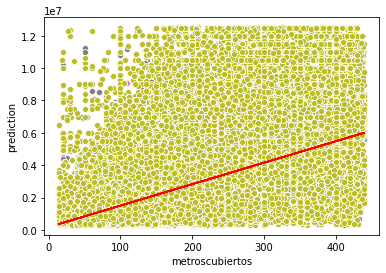

In [2]:

import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *

!pwd
!python --version
import metnum

def calculate_metrics(variable_to_predict, df_old):
    df = df_old.copy(deep=True)
    df = df[df['prediction'].notna()]
    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))

def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df_old,
         data):
            
    df = df_old.copy(deep=True)
    
    t0 = time.time()
        
    df = df[0:].sample(frac=1, random_state=seed)
    
    #cleanup
    df = df[df[variable_to_predict].notna()]
    for var in variables_to_study:
        df = df[df[var].notna()]
        
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))
    
    df_prediction = df[TOTAL_TRAIN_CASES:].copy(deep=True)

    df = df[:TOTAL_TRAIN_CASES]

    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)

    t1 = time.time()
    total_time = (t1-t0)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    data['time'].append(total_time)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction
    
df = pd.read_csv('../data/train.csv')

variable_to_predict = 'precio'
variables_to_study = ['metroscubiertos']

#cleanup
df = df[df[variable_to_predict].notna()]
for var in variables_to_study:
    df = df[df[var].notna()]

d = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}

folder='./test_m2_vs_precios_{}'.format(int(time.time()))
os.mkdir(folder)

for j in np.arange(1,10,1):
    df_prediction = experiment(0.9, variable_to_predict, variables_to_study, j*10, df, d)
    df_prediction.to_csv(folder+'/prediction_m2cubiertos_y_precios'+str(j)+'.csv', encoding='utf-8', index=False)
    print('\n--------------\n')

df_error = pd.DataFrame(data=d)
print('Error promedio RMSLE: '+str(df_error['rmsle'].mean()))
df_error.to_csv(folder+'/error_m2_vs_precios.csv', encoding='utf-', index=False)


